Code repurposed from Kaggle [https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-cryptocurrencies]

## import dependencies

In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from pathlib import Path
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from yahoo_fin.stock_info import get_data

%matplotlib inline

## load and inspect data

In [2]:
crypto_currency = 'USDT'
against_currency = 'USD'

start = dt.datetime(2014,1,1)
end = dt.datetime.now()

base_df = get_data(f'{crypto_currency}-{against_currency}', start, end, index_as_date = True, interval = '1d')
base_df

,open,high,low,close,adjclose,volume,ticker
2015-02-25,1.210160,1.215490,1.209580,1.211100,1.211100,6.000000e+00,USDT-USD
2015-02-26,1.210420,1.212320,1.194710,1.205740,1.205740,6.000000e+00,USDT-USD
2015-02-27,NaN,NaN,NaN,NaN,NaN,NaN,USDT-USD
2015-02-28,NaN,NaN,NaN,NaN,NaN,NaN,USDT-USD
2015-03-01,NaN,NaN,NaN,NaN,NaN,NaN,USDT-USD
...,...,...,...,...,...,...,...
2021-07-03,0.999987,1.000165,0.998902,0.999501,0.999501,4.306666e+10,USDT-USD
2021-07-04,0.999426,1.001040,0.999426,1.000667,1.000667,4.721585e+10,USDT-USD
2021-07-05,1.000728,1.000879,0.999825,1.000090,1.000090,5.105419e+10,USDT-USD
2021-07-06,1.000022,1.000792,0.999772,1.000708,1.000708,5.037083e+10,USDT-USD


In [3]:
base_df['spread'] = base_df.high - base_df.low
base_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2326 entries, 2015-02-25 to 2021-07-08
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      2317 non-null   float64
 1   high      2317 non-null   float64
 2   low       2317 non-null   float64
 3   close     2317 non-null   float64
 4   adjclose  2317 non-null   float64
 5   volume    2317 non-null   float64
 6   ticker    2326 non-null   object 
 7   spread    2317 non-null   float64
dtypes: float64(7), object(1)
memory usage: 163.5+ KB


## Plot the closing value of Tether over time

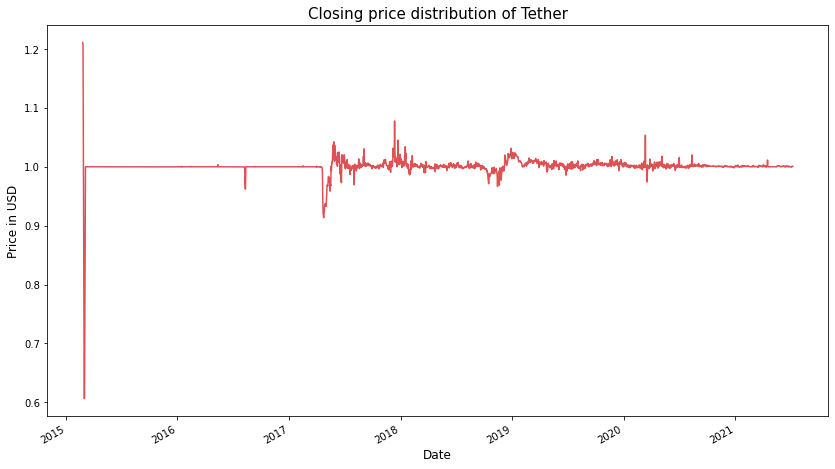

In [4]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14,8))

sns.lineplot(y = base_df.close.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Closing price distribution of Tether", fontsize=15)
plt.show()

Text(0.5, 1.0, 'Daily price spread of Tether')

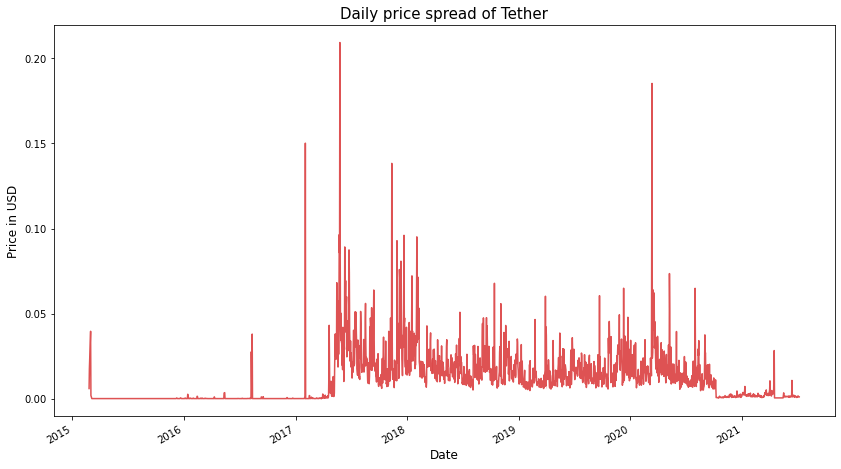

In [5]:
fig, ax = plt.subplots(figsize=(14,8))

sns.lineplot(y = base_df.spread.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Daily price spread of Tether", fontsize=15)

## Candlestick chart

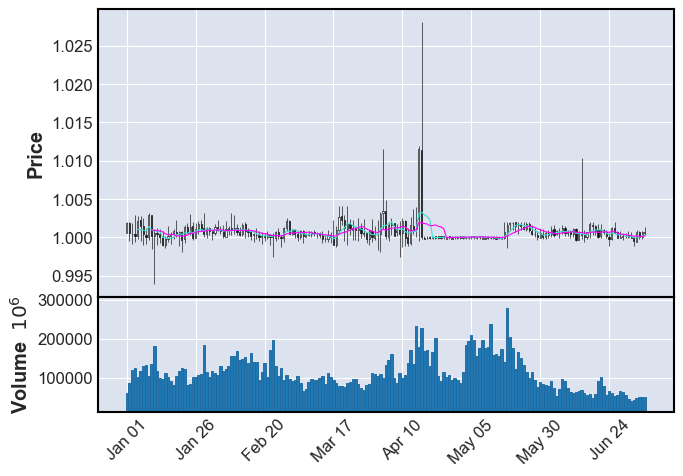

In [11]:
import matplotlib.ticker as mticker
import mplfinance as mpf

temp_base_df = base_df.copy(deep=False)

temp_base_df = temp_base_df.drop(['spread'], axis=1)
mpf.plot(temp_base_df.loc['2021-1-1':], type='candle', mav=(5,10), volume=True)

## Future Price Prediction

In [7]:
from fbprophet import Prophet

In [8]:
price_predict_df = base_df['close'].copy(deep=False).reset_index()
price_predict_df.columns = ["ds", "y"]
#price_predict_df = price_predict_df[price_predict_df['ds']>'2020-6-1']
price_predict_df

,ds,y
0,2015-02-25,1.211100
1,2015-02-26,1.205740
2,2015-02-27,NaN
3,2015-02-28,NaN
4,2015-03-01,NaN
...,...,...
2321,2021-07-03,0.999501
2322,2021-07-04,1.000667
2323,2021-07-05,1.000090
2324,2021-07-06,1.000708


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
2344,2021-08-03,0.997270,0.977645,1.016131
2345,2021-08-04,0.998817,0.979184,1.017649
2346,2021-08-05,0.999859,0.981982,1.018269
2347,2021-08-06,0.998721,0.978503,1.017904
2348,2021-08-07,0.999192,0.979856,1.018069


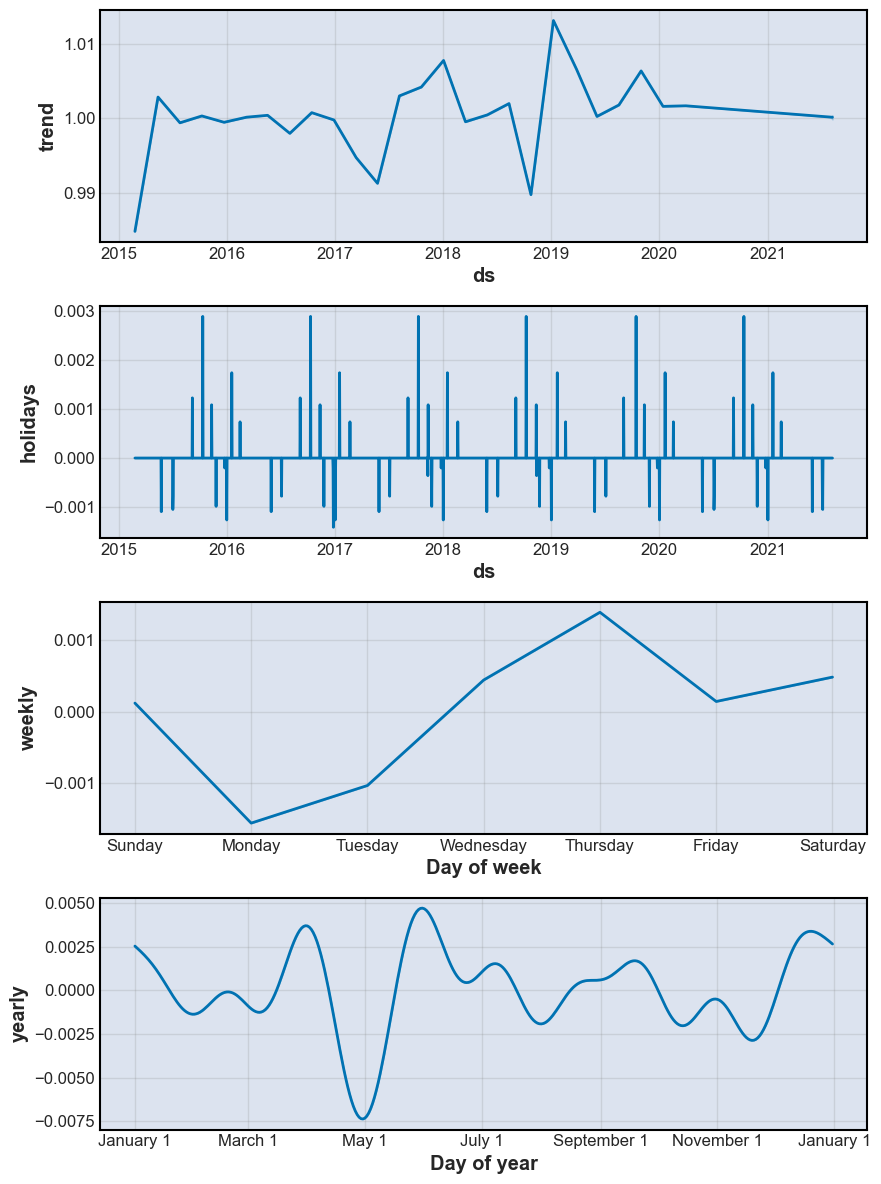

In [9]:
m = Prophet(changepoint_prior_scale=.7)
m.add_country_holidays(country_name='US')
#m.add_country_holidays(country_name='CN')
m.fit(price_predict_df);
m.train_holiday_names

future = m.make_future_dataframe(periods=30)

forecast = m.predict(future)
fig = m.plot_components(forecast)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

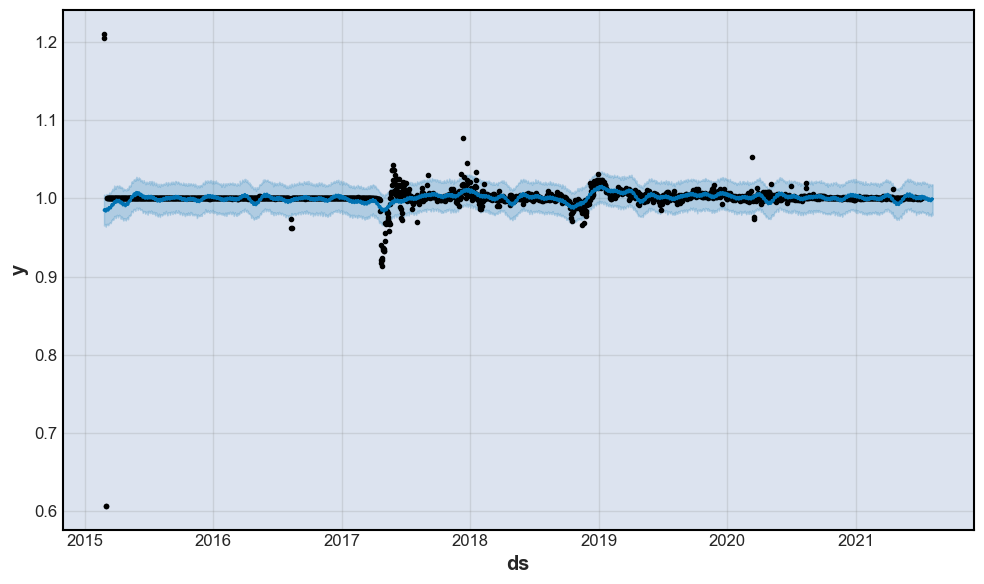

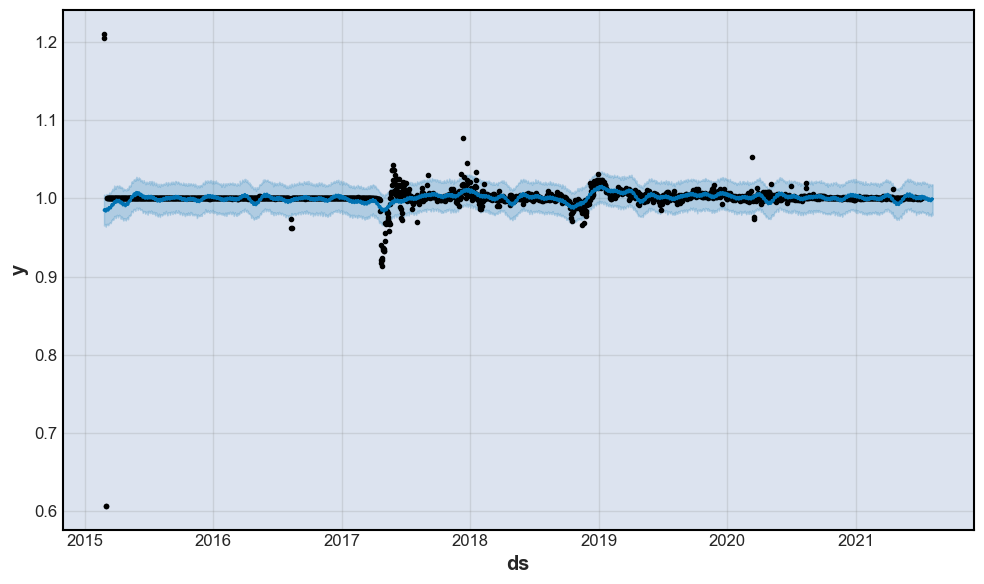

In [10]:
m.plot(forecast)